In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import functools
import numpy.typing as npt

from benchmarks import *
from data_utils import read_crsp_data

In [3]:
df = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", skiprows=4, nrows=25710)
df['date'] = pd.to_datetime(df['Unnamed: 0'], format='%Y%m%d')
df.index = df.date
df_rf = df['RF'].astype(float) / 252

In [4]:
idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
  'DATE': 'string',
  'vwretd': float
})
idx_df.DATE = pd.to_datetime(idx_df.DATE)
idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
idx_df.set_index('DATE', inplace=True)

In [6]:
with open('naive_equal_results.pkl', 'rb') as f:
  res = pkl.load(f)
TIMES_ARR = res['times_arr']
SNP_VAL = (1 + idx_df.vwretd[TIMES_ARR].values).cumprod()

In [11]:
def summarize_results(result_tuples: tuple[str, str], title: str, yscale: str | None = None):
  stats = {}
  port_vals = {}

  for (label, filename) in result_tuples:
    with open(filename, 'rb') as f:
      results = pkl.load(f)
      port_val = np.array(results['port_val'])
      port_vals[label] = port_val
      rf = df_rf[TIMES_ARR[1:]]
      rets = port_val[1:] / port_val[:-1] - 1
    
    sharpe = sharpe_ratio(rets, rf=rf, annualized=True)
    sortino = sortino_ratio(rets, 0, rf=rf, annualized=True)
    drawdown = max_drawdown(rets)
    stats[label] = [port_val[-1]-1, sharpe, sortino, drawdown]

  port_vals['S&P'] = SNP_VAL
  rets = SNP_VAL[1:] / SNP_VAL[:-1] - 1
  sharpe = sharpe_ratio(rets, rf=rf, annualized=True)
  sortino = sortino_ratio(rets, 0, rf=rf, annualized=True)
  drawdown = max_drawdown(rets)
  stats['S&P'] = [SNP_VAL[-1]-1, sharpe, sortino, drawdown]

  plt.figure(figsize=(8, 6))
  for label, port_val in port_vals.items():
    plt.plot(TIMES_ARR, port_val, label=label, lw=1)
  if yscale == 'exp':
    plt.yscale('function', functions=(functools.partial(np.power, 100.0), lambda x: np.log10(x)/2))
  plt.legend()
  plt.title(title)
  plt.savefig(f'./figures/{title}')
  plt.show()

  stats_df = pd.DataFrame(stats, index=["Net Profit", "Sharpe Ratio", "Sortino Ratio", "Max Drawdown"])
  display(stats_df.T)

## Benchmarks

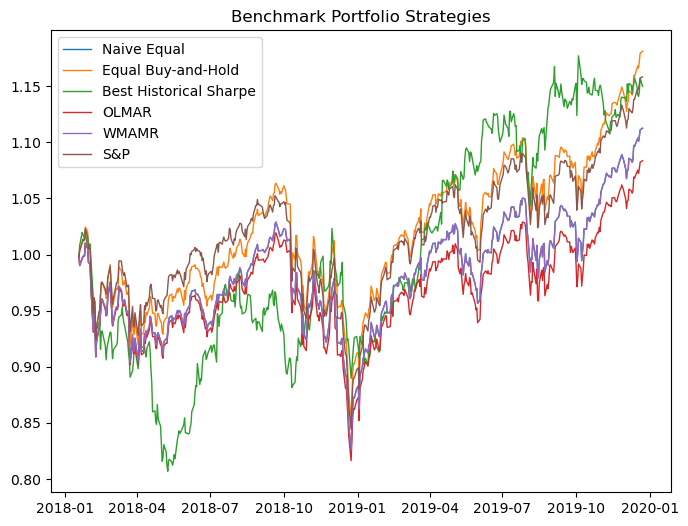

,Net Profit,Sharpe Ratio,Sortino Ratio,Max Drawdown
Naive Equal,0.112583,0.392352,-14.464945,0.197294
Equal Buy-and-Hold,0.181138,0.595225,-14.009800,0.198039
Best Historical Sharpe,0.149857,0.475577,-16.749871,0.210250
OLMAR,0.083634,0.300906,-14.344610,0.199240
WMAMR,0.112565,0.392310,-14.464168,0.197294
S&P,0.158347,0.552242,-14.756129,0.197728


In [12]:
result_tuples = [
  ('Naive Equal', 'naive_equal_results.pkl'),
  ('Equal Buy-and-Hold', 'equal_and_hold_results.pkl'),
  ('Best Historical Sharpe', 'best_sharpe_stock_results.pkl'),
  ('OLMAR', 'olmar_1.1_results_decent.pkl'),
  ('WMAMR', 'wmamr_1.1_results_decent.pkl')
]
summarize_results(result_tuples, 'Benchmark Portfolio Strategies')

## Historical Prices (DiffSharpe)

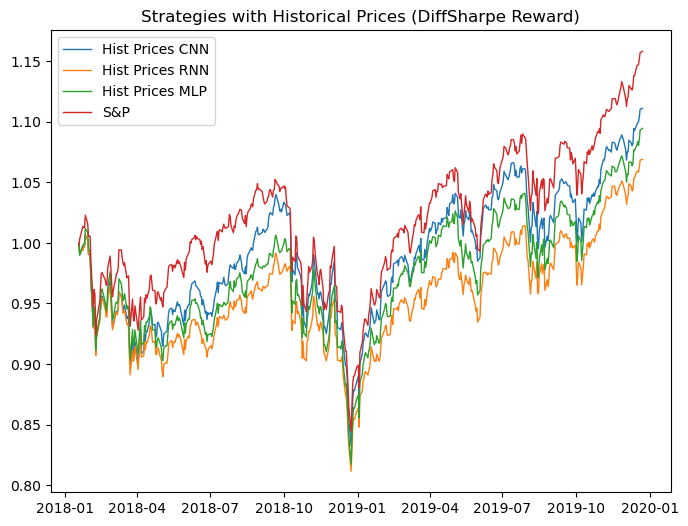

,Net Profit,Sharpe Ratio,Sortino Ratio,Max Drawdown
Hist Prices CNN,0.111205,0.396336,-14.459686,0.199721
Hist Prices RNN,0.069154,0.262906,-14.991369,0.194177
Hist Prices MLP,0.094686,0.338142,-14.739489,0.188082
S&P,0.158347,0.552242,-14.756129,0.197728


In [13]:
result_ruples = [
  ('Hist Prices CNN', 'pure_cnn_0.02_diffsharpe_results.pkl'),
  ('Hist Prices RNN', 'pure_rnn_0.08_diffsharpe_results.pkl'),
  ('Hist Prices MLP', 'pure_mlp_0.07_diffsharpe_results.pkl')
]
summarize_results(result_ruples, 'Strategies with Historical Prices (DiffSharpe Reward)')

## Historical Prices (Profit)

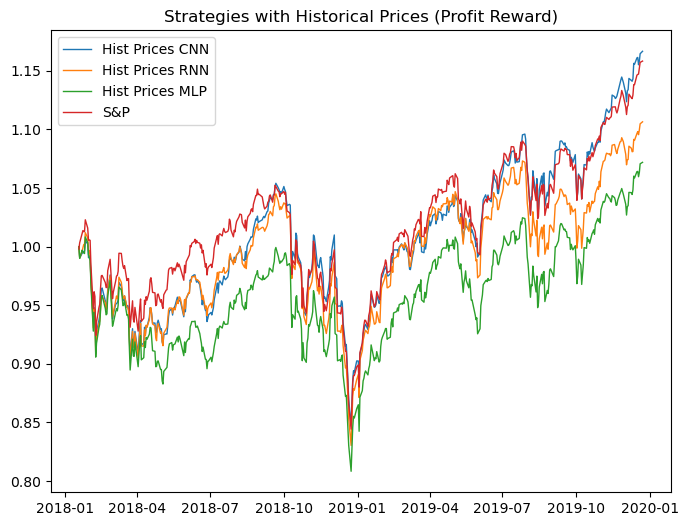

,Net Profit,Sharpe Ratio,Sortino Ratio,Max Drawdown
Hist Prices CNN,0.166717,0.561471,-14.923095,0.196557
Hist Prices RNN,0.106518,0.369764,-15.113139,0.205465
Hist Prices MLP,0.071937,0.261355,-15.265520,0.198329
S&P,0.158347,0.552242,-14.756129,0.197728


In [15]:
result_tuples = [
  ('Hist Prices CNN', 'pure_cnn_0.02_profit_results.pkl'),
  ('Hist Prices RNN', 'pure_rnn_0.04_profit_results.pkl'),
  ('Hist Prices MLP', 'pure_mlp_0.04_profit_results.pkl')
]
summarize_results(result_tuples, 'Strategies with Historical Prices (Profit Reward)')

## SEC Data (DiffSharpe)

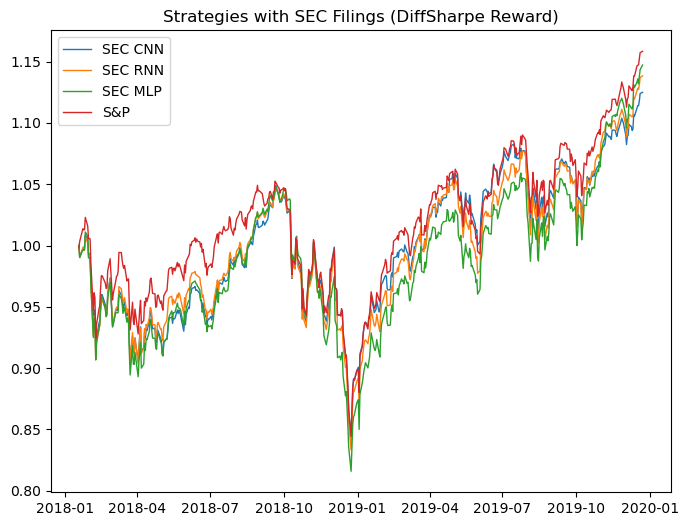

,Net Profit,Sharpe Ratio,Sortino Ratio,Max Drawdown
SEC CNN,0.124870,0.439863,-14.397950,0.195347
SEC RNN,0.138309,0.464039,-14.439768,0.204159
SEC MLP,0.147103,0.482788,-14.519536,0.220906
S&P,0.158347,0.552242,-14.756129,0.197728


In [16]:
result_tuples = [
  ('SEC CNN', 'sec_cnn_results.pkl'),
  ('SEC RNN', 'sec_rnn_results.pkl'),
  ('SEC MLP', 'sec_mlp_results.pkl')
]
summarize_results(result_tuples, 'Strategies with SEC Filings (DiffSharpe Reward)')

## SEC Data (Profit)

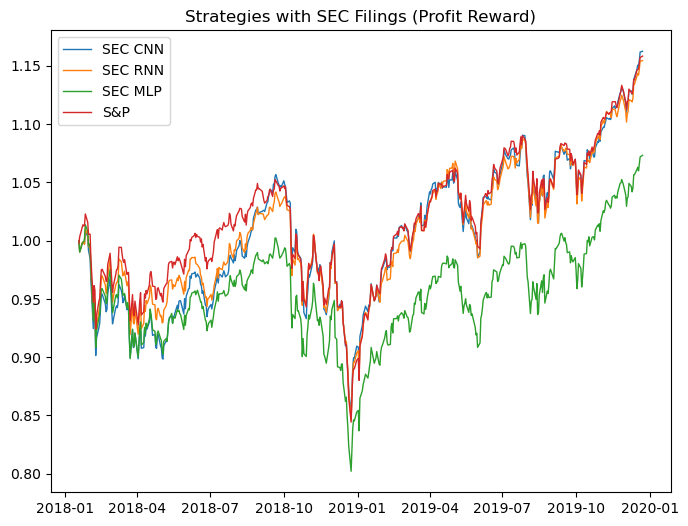

,Net Profit,Sharpe Ratio,Sortino Ratio,Max Drawdown
SEC CNN,0.162534,0.532298,-14.478839,0.195766
SEC RNN,0.154506,0.513757,-14.728491,0.187671
SEC MLP,0.073242,0.266018,-15.909619,0.208675
S&P,0.158347,0.552242,-14.756129,0.197728


In [17]:
result_tuples = [
  # ('SEC CNN', 'sec_cnn_profit_0.02_gcloud.pkl'),
  ('SEC CNN', 'sec_cnn_profit_optimal.pkl'),
  # ('SEC RNN', 'sec_rnn_results_profit.pkl'),
  ('SEC RNN', 'sec_rnn_profit_optimal.pkl'),
  ('SEC MLP', 'sec_mlp_results_profit.pkl')
]
summarize_results(result_tuples, 'Strategies with SEC Filings (Profit Reward)')

## Combined Data (DiffSharpe)

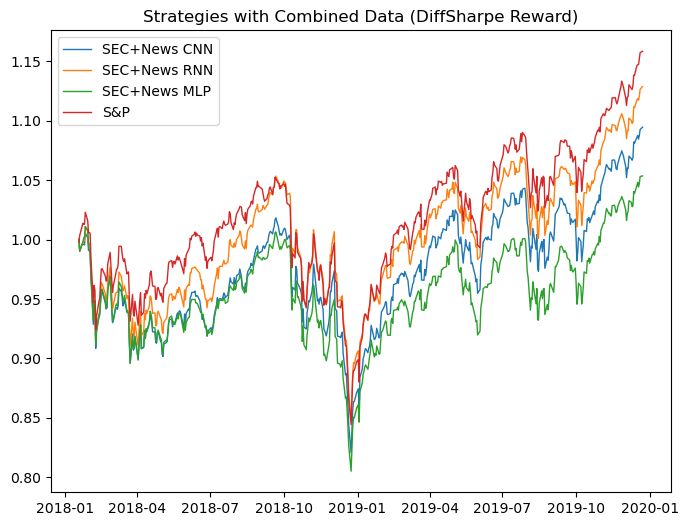

,Net Profit,Sharpe Ratio,Sortino Ratio,Max Drawdown
SEC+News CNN,0.094546,0.342485,-14.805659,0.193996
SEC+News RNN,0.128636,0.444354,-14.533568,0.195274
SEC+News MLP,0.053514,0.205204,-15.149644,0.200069
S&P,0.158347,0.552242,-14.756129,0.197728


In [18]:
result_results = [
  ('SEC+News CNN', 'sec_and_news_cnn_results.pkl'),
  ('SEC+News RNN', 'sec_and_news_rnn_results.pkl'),
  ('SEC+News MLP', 'sec_and_news_mlp_results.pkl')
]
summarize_results(result_results, 'Strategies with Combined Data (DiffSharpe Reward)')

## Combined Data (Profit)

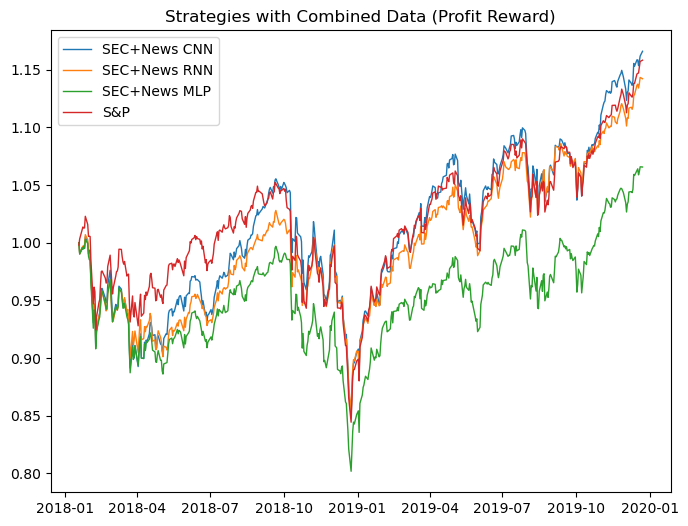

,Net Profit,Sharpe Ratio,Sortino Ratio,Max Drawdown
SEC+News CNN,0.166081,0.553644,-14.319155,0.195472
SEC+News RNN,0.142287,0.519258,-14.759413,0.170134
SEC+News MLP,0.065676,0.248586,-14.917642,0.195750
S&P,0.158347,0.552242,-14.756129,0.197728


In [19]:
result_tuples = [
  ('SEC+News CNN', 'combined_cnn_optimal_results.pkl'),
  ('SEC+News RNN', 'combined_rnn_0.08_results.pkl'),
  ('SEC+News MLP', 'combined_mlp_0.07_results.pkl')
]
summarize_results(result_tuples, 'Strategies with Combined Data (Profit Reward)')

## Comparing Best

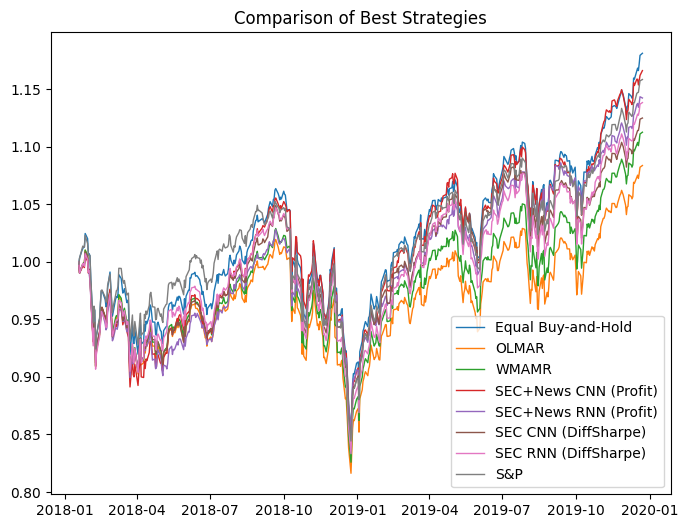

,Net Profit,Sharpe Ratio,Sortino Ratio,Max Drawdown
Equal Buy-and-Hold,0.181138,0.595225,-14.009800,0.198039
OLMAR,0.083634,0.300906,-14.344610,0.199240
WMAMR,0.112565,0.392310,-14.464168,0.197294
SEC+News CNN (Profit),0.166081,0.553644,-14.319155,0.195472
SEC+News RNN (Profit),0.142287,0.519258,-14.759413,0.170134
SEC CNN (DiffSharpe),0.124870,0.439863,-14.397950,0.195347
SEC RNN (DiffSharpe),0.138309,0.464039,-14.439768,0.204159
S&P,0.158347,0.552242,-14.756129,0.197728


In [49]:
result_tuples = [
  ('Equal Buy-and-Hold', 'equal_and_hold_results.pkl'),
  ('OLMAR', 'olmar_1.1_results_decent.pkl'),
  ('WMAMR', 'wmamr_1.1_results_decent.pkl'),
  ('SEC+News CNN (Profit)', 'combined_cnn_optimal_results.pkl'),
  ('SEC+News RNN (Profit)', 'combined_rnn_0.08_results.pkl'),
  ('SEC CNN (DiffSharpe)', 'sec_cnn_results.pkl'),
  ('SEC RNN (DiffSharpe)', 'sec_rnn_results.pkl'),
]
summarize_results(result_tuples, 'Comparison of Best Strategies')

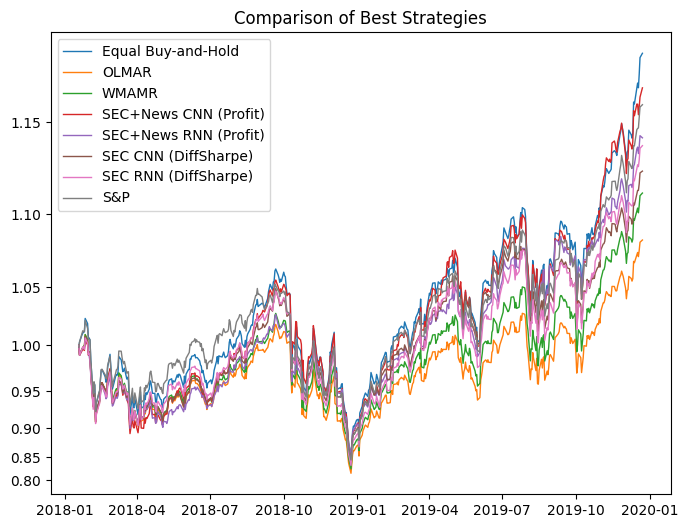

,Net Profit,Sharpe Ratio,Sortino Ratio,Max Drawdown
Equal Buy-and-Hold,0.181138,0.595225,-14.009800,0.198039
OLMAR,0.083634,0.300906,-14.344610,0.199240
WMAMR,0.112565,0.392310,-14.464168,0.197294
SEC+News CNN (Profit),0.166081,0.553644,-14.319155,0.195472
SEC+News RNN (Profit),0.142287,0.519258,-14.759413,0.170134
SEC CNN (DiffSharpe),0.124870,0.439863,-14.397950,0.195347
SEC RNN (DiffSharpe),0.138309,0.464039,-14.439768,0.204159
S&P,0.158347,0.552242,-14.756129,0.197728


In [50]:
result_tuples = [
  ('Equal Buy-and-Hold', 'equal_and_hold_results.pkl'),
  ('OLMAR', 'olmar_1.1_results_decent.pkl'),
  ('WMAMR', 'wmamr_1.1_results_decent.pkl'),
  ('SEC+News CNN (Profit)', 'combined_cnn_optimal_results.pkl'),
  ('SEC+News RNN (Profit)', 'combined_rnn_0.08_results.pkl'),
  ('SEC CNN (DiffSharpe)', 'sec_cnn_results.pkl'),
  ('SEC RNN (DiffSharpe)', 'sec_rnn_results.pkl'),
]
summarize_results(result_tuples, 'Comparison of Best Strategies', yscale='exp')

## Side-by-Side Plots

In [72]:
L1 = [
  ('Hist Prices CNN', 'pure_cnn_0.02_diffsharpe_results.pkl'),
  ('Hist Prices RNN', 'pure_rnn_0.08_diffsharpe_results.pkl'),
  ('Hist Prices MLP', 'pure_mlp_0.07_diffsharpe_results.pkl')
]
L2 = [
  ('SEC CNN', 'sec_cnn_results.pkl'),
  ('SEC RNN', 'sec_rnn_results.pkl'),
  ('SEC MLP', 'sec_mlp_results.pkl')
]
L3 = [
  ('SEC+News CNN', 'sec_and_news_cnn_results.pkl'),
  ('SEC+News RNN', 'sec_and_news_rnn_results.pkl'),
  ('SEC+News MLP', 'sec_and_news_MLP_results.pkl')
]
R1 = [
  ('Hist Prices CNN', 'pure_cnn_0.02_profit_results.pkl'),
  ('Hist Prices RNN', 'pure_rnn_0.04_profit_results.pkl'),
  ('Hist Prices MLP', 'pure_mlp_0.04_profit_results.pkl')
]
R2 = [
  # ('SEC CNN', 'sec_cnn_profit_0.02_gcloud.pkl'),
  ('SEC CNN', 'sec_cnn_profit_optimal.pkl'),
  # ('SEC RNN', 'sec_rnn_results_profit.pkl'),
  ('SEC RNN', 'sec_rnn_profit_optimal.pkl'),
  ('SEC MLP', 'sec_mlp_results_profit.pkl')
]
R3 = [
  ('SEC+News CNN', 'combined_cnn_optimal_results.pkl'),
  ('SEC+News RNN', 'combined_rnn_0.08_results.pkl'),
  ('SEC+News MLP', 'combined_mlp_0.07_results.pkl')
]
all_results = {
  'Historical DiffSharpe': L1,
  'Historical Profit': R1,
  'SEC DiffSharpe': L2,
  'SEC Profit': R2,
  'Combined DiffSharpe': L3,
  'Combined Profit': R3
}

In [66]:
def create_value_arrays(result_tuples: tuple[str, str]) -> list[dict[str, npt.NDArray]]:
  port_vals = {}
  for (label, filename) in result_tuples:
    with open(filename, 'rb') as f:
      results = pkl.load(f)
      port_val = np.array(results['port_val'])
      port_vals[label] = port_val
  port_vals['S&P'] = SNP_VAL
  return port_vals

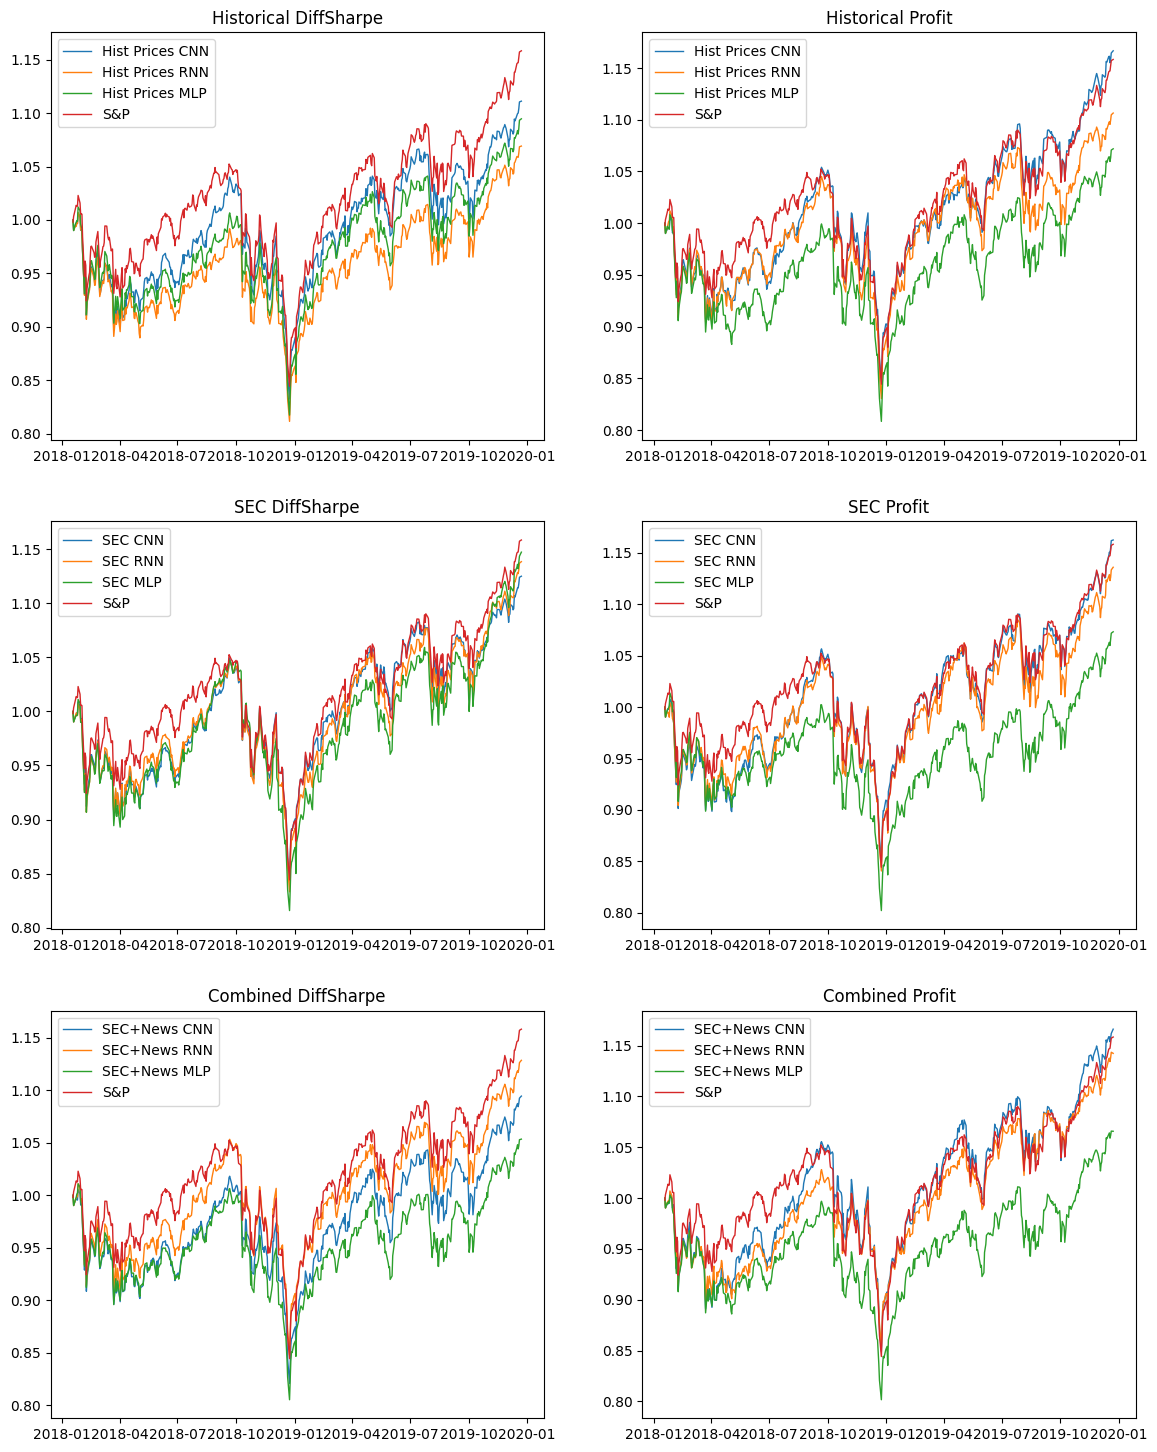

In [67]:
fig, ax = plt.subplots(3, 2, figsize=(14, 18))
for i, (title, result_tuples) in enumerate(all_results.items()):
  port_vals = create_value_arrays(result_tuples)
  for label, port_val in port_vals.items():
    ax[i//2, i%2].plot(TIMES_ARR, port_val, label=label, lw=1)
  ax[i//2, i%2].legend()
  ax[i//2, i%2].set_title(title)